# Import librairies

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [ ]:
data = pd.read_csv('df_rio_interpolado.csv')

In [ ]:
data.head(5)

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Ajustar o scaler e transformar os dados na coluna TEMP
scaled_data = scaler.fit_transform(data[['TEMP']])

In [ ]:
# Salvar o scaler para uso posterior (por exemplo, para reverter a padronização)
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
# Verificar os dados padronizados
print(data.head())

## Train test split

In [ ]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [ ]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


In [ ]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

In [ ]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

In [ ]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = scaled_data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

In [ ]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [ ]:
epochs = 10
batch = 32
lr = 0.001
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=adam)
model_mlp.summary()

In [ ]:
mlp_history = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

In [ ]:
model_reg = Sequential()
model_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(1))  # Saída
model_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_reg.summary()

In [ ]:
mlp_reg_history = model_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

In [ ]:
model_dropout = Sequential()
model_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(1))  # Saída
model_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_dropout.summary()



In [ ]:
mlp_drop_history = model_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

## Comparando os 3 modelos

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return mae, mse, rmse

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg = evaluate_model(model_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout = evaluate_model(model_dropout, X_test, Y_test, "Modelo com Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}")


In [ ]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(mlp_history.history['loss'], label='Treinamento')
plt.plot(mlp_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(mlp_reg_history.history['loss'], label='Treinamento')
plt.plot(mlp_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(mlp_drop_history.history['loss'], label='Treinamento')
plt.plot(mlp_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# # Modelo com Regularização e Dropout
# plt.subplot(2, 2, 4)
# plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
# plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
# plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
# plt.xlabel('Épocas')
# plt.ylabel('Perda')
# plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_reg = model_reg.predict(X_test)
y_pred_drop = model_dropout.predict(X_test)

# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta
    
    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]
        
        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
        
        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
        
        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
        
        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_reg, y_pred_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
#Hiperparametros
epochs = 20
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [ ]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

## Aplicando Modelo CNN

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

## Aplicando Regularização

In [ ]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_reg.summary()


In [ ]:
cnn_reg_history = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

## Aplicando Dropout

In [ ]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada de pooling
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada densa
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_drop.summary()

In [ ]:
cnn_drop_history = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs, 
                                       verbose=2)


## Aplicando Regularização e Dropout combinados

In [ ]:
model_cnn_regdrop = Sequential()
model_cnn_regdrop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_regdrop.add(MaxPooling1D(pool_size=2))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Flatten())
model_cnn_regdrop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Dense(1))
model_cnn_regdrop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_regdrop.summary()

In [ ]:
cnn_regdrop_history = model_cnn_regdrop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs, 
                                             verbose=2)


## Preivsao dos Modelos

In [ ]:
# Previsões
predictions_simple = model_cnn.predict(X_test)
predictions_reg = model_cnn_reg.predict(X_test)
predictions_drop = model_cnn_drop.predict(X_test)
predictions_regdrop = model_cnn_regdrop.predict(X_test)


In [ ]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_simple),
        "MSE": mean_squared_error(Y_test, predictions_simple),
        "RMSE": root_mean_squared_error(Y_test, predictions_simple)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_reg),
        "MSE": mean_squared_error(Y_test, predictions_reg),
        "RMSE": root_mean_squared_error(Y_test, predictions_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_drop),
        "MSE": mean_squared_error(Y_test, predictions_drop),
        "RMSE": root_mean_squared_error(Y_test, predictions_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_regdrop),
        "MSE": mean_squared_error(Y_test, predictions_regdrop),
        "RMSE": root_mean_squared_error(Y_test, predictions_regdrop)
    }
}

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")


In [ ]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], label='Treinamento')
plt.plot(cnn_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(cnn_reg_history.history['loss'], label='Treinamento')
plt.plot(cnn_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(cnn_drop_history.history['loss'], label='Treinamento')
plt.plot(cnn_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_simple, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_regdrop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Gráficos de ajuste no conjunto de treinamento e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_simple)), predictions_simple, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo Simples: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_reg)), predictions_reg, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_drop)), predictions_drop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_regdrop)), predictions_regdrop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização e Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, predictions_simple, "CNN Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_reg, "CNN com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_drop, "CNN com Dropout")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_regdrop, "CNN com Regularização e Dropout")

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [163]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)


## Implementacao e Ajustei do Modelo Padrao

In [168]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
#model_lstm.summary()

In [176]:
history_lstm = model_lstm.fit(X_train_series, 
                              Y_train, 
                              validation_data=(X_valid_series, Y_valid), 
                              epochs=15,
                                verbose=2)

Epoch 1/15
11/11 - 3s - 228ms/step - loss: 0.1546 - val_loss: 0.0542
Epoch 2/15
11/11 - 0s - 23ms/step - loss: 0.0616 - val_loss: 0.0547
Epoch 3/15
11/11 - 0s - 22ms/step - loss: 0.0548 - val_loss: 0.0559
Epoch 4/15
11/11 - 0s - 23ms/step - loss: 0.0526 - val_loss: 0.0523
Epoch 5/15
11/11 - 0s - 22ms/step - loss: 0.0503 - val_loss: 0.0503
Epoch 6/15
11/11 - 0s - 23ms/step - loss: 0.0484 - val_loss: 0.0486
Epoch 7/15
11/11 - 0s - 22ms/step - loss: 0.0468 - val_loss: 0.0468
Epoch 8/15
11/11 - 0s - 22ms/step - loss: 0.0450 - val_loss: 0.0449
Epoch 9/15
11/11 - 0s - 22ms/step - loss: 0.0433 - val_loss: 0.0429
Epoch 10/15
11/11 - 0s - 22ms/step - loss: 0.0415 - val_loss: 0.0407
Epoch 11/15
11/11 - 0s - 22ms/step - loss: 0.0395 - val_loss: 0.0382
Epoch 12/15
11/11 - 0s - 22ms/step - loss: 0.0374 - val_loss: 0.0355
Epoch 13/15
11/11 - 0s - 30ms/step - loss: 0.0353 - val_loss: 0.0326
Epoch 14/15
11/11 - 0s - 22ms/step - loss: 0.0332 - val_loss: 0.0296
Epoch 15/15
11/11 - 0s - 22ms/step - loss:

## Implementacao e Ajuste do Modelo com Regularizacao L2

In [171]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer='adam', loss='mse')
#model_lstm_reg.summary()


In [174]:
# Treinamento do modelo com regularização L2
history_lstm_reg = model_lstm_reg.fit(X_train_series, 
                                      y_train, 
                                      epochs=50, 
                                      batch_size=32, 
                                      validation_split=0.2, 
                                      verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1574 - val_loss: 0.0700
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0722 - val_loss: 0.0647
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0620 - val_loss: 0.0645
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0584 - val_loss: 0.0593
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0561 - val_loss: 0.0568
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0528 - val_loss: 0.0547
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0500 - val_loss: 0.0519
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0473 - val_loss: 0.0492
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0440 - val_loss: 0.0457
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0401 - val_loss: 0.0407
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0350 - val_loss: 0.0325
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0283 - val_loss: 0.0205
E

## Implementacao e Ajuste do Modelo com Dropout

In [172]:
model_lstm_dropout = Sequential()
model_lstm_dropout.add(LSTM(64, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_dropout.add(Dense(1))
model_lstm_dropout.compile(optimizer='adam', loss='mse')
#model_lstm_dropout.summary()


In [175]:
# Treinamento do modelo com Dropout
history_lstm_dropout = model_lstm_dropout.fit(X_train_series, 
                                              y_train, 
                                              epochs=50, 
                                              batch_size=32, 
                                              validation_split=0.2, 
                                              verbose=1)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.2180 - val_loss: 0.0626
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0510 - val_loss: 0.0475
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0473 - val_loss: 0.0517
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0452 - val_loss: 0.0454
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0421 - val_loss: 0.0439
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0420 - val_loss: 0.0437
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0375 - val_loss: 0.0423
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0386 - val_loss: 0.0412
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0381 - val_loss: 0.0401
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0349 - val_loss: 0.0380
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0350 - val_loss: 0.0357
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0326 - val_loss: 0.0322
E

## Implementacao e Ajuste do modelo com Regularizacao e Dropout

In [179]:
model_lstm_reg_dropout = Sequential()
model_lstm_reg_dropout.add(
    LSTM(
        50, 
        activation='tanh', 
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_dropout.add(Dropout(0.2))  # Dropout de 20%
model_lstm_reg_dropout.add(Dense(1))
model_lstm_reg_dropout.compile(loss='mse', optimizer='adam')
#model_lstm_reg_dropout.summary()


In [180]:
history_lstm_reg_dropout = model_lstm_reg_dropout.fit(
    X_train_series, 
    y_train, 
    epochs=50,  # Use o mesmo número de épocas dos outros modelos
    batch_size=32, 
    validation_split=0.2
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1855 - val_loss: 0.0881
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0734 - val_loss: 0.0696
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0670 - val_loss: 0.0638
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0619 - val_loss: 0.0626
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0588 - val_loss: 0.0582
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0567 - val_loss: 0.0561
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0560 - val_loss: 0.0544
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0521 - val_loss: 0.0528
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0495 - val_loss: 0.0509
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0467 - val_loss: 0.0489
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0466 - val_loss: 0.0468
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0428 - val_loss: 0.0441
E

## Comparativo entre os modelos - Predicao e Validacao

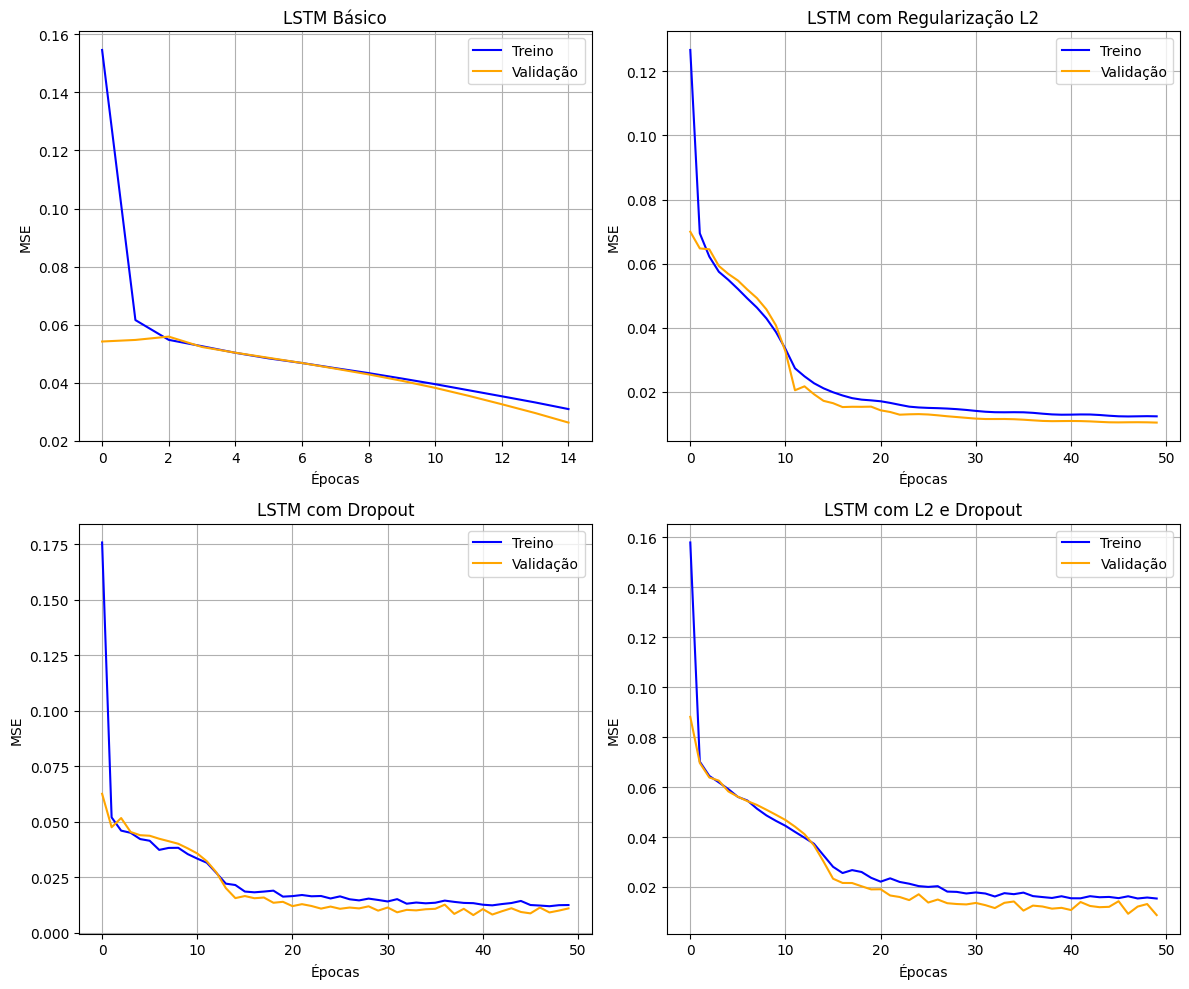

In [182]:
# Lista dos históricos e títulos dos modelos
histories = [history_lstm, history_lstm_reg, history_lstm_dropout, history_lstm_reg_dropout]
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()  # Facilita iterar sobre os eixos

# Plotando cada modelo
for i, history in enumerate(histories):
    axes[i].plot(history.history['loss'], label='Treino', color='blue')
    axes[i].plot(history.history['val_loss'], label='Validação', color='orange')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Épocas')
    axes[i].set_ylabel('MSE')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


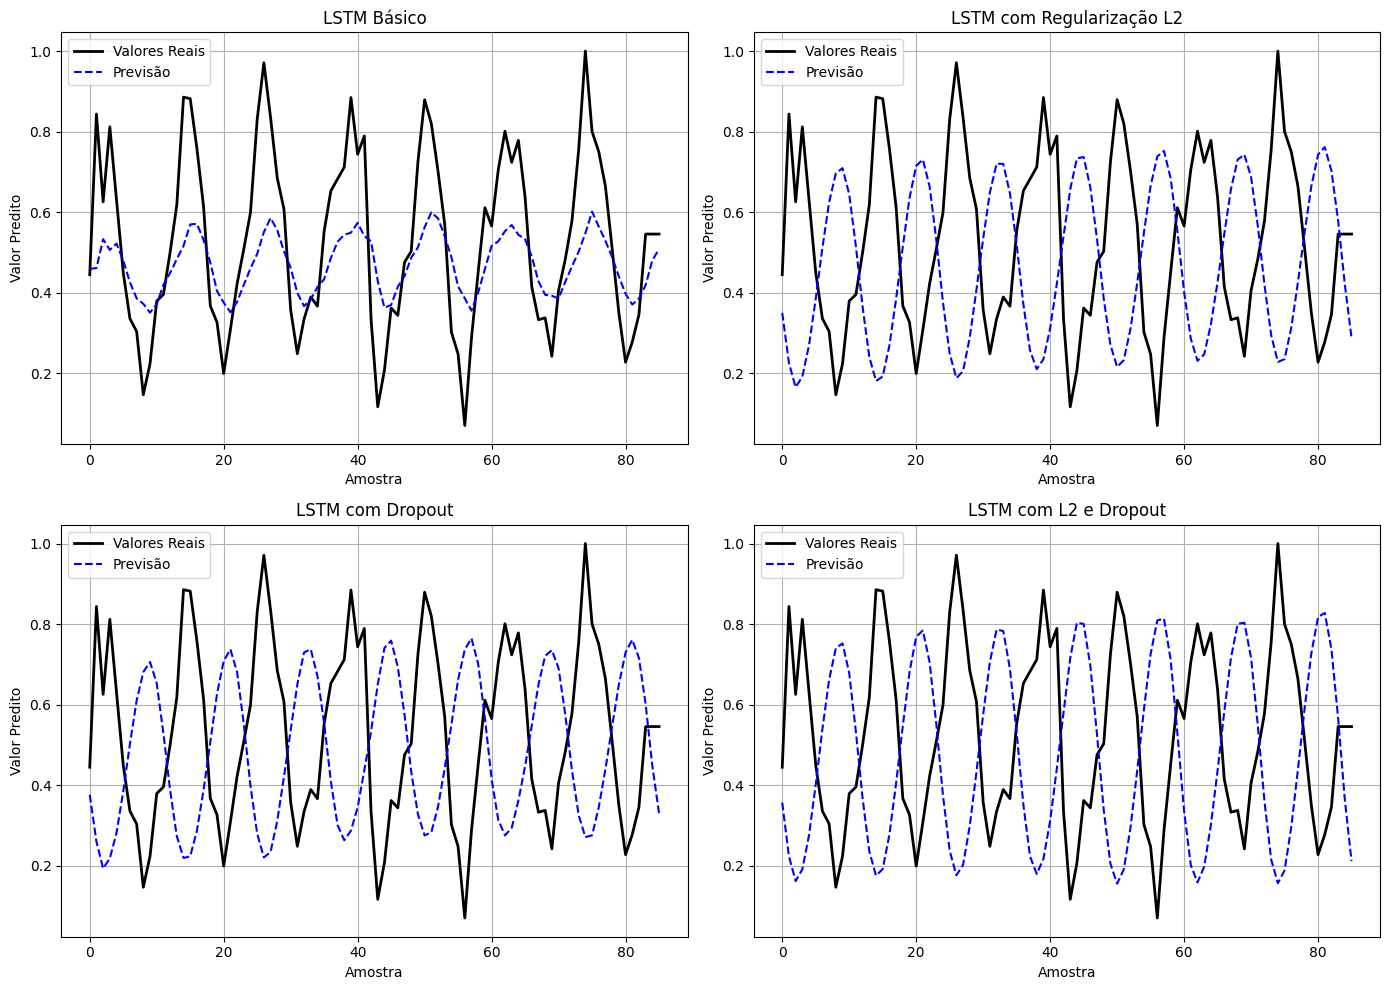

In [186]:
# Obtendo as previsões dos quatro modelos
pred_lstm = model_lstm.predict(X_test_series)
pred_lstm_reg = model_lstm_reg.predict(X_test_series)
pred_lstm_dropout = model_lstm_dropout.predict(X_test_series)
pred_lstm_reg_dropout = model_lstm_reg_dropout.predict(X_test_series)

# Títulos para cada gráfico
titles = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Criando a figura com 2 linhas e 2 colunas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()  # Facilita a iteração sobre os eixos

# Plotando cada modelo
for i, (pred, title) in enumerate(zip([pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout], titles)):
    axes[i].plot(Y_test, label='Valores Reais', color='black', linewidth=2)
    axes[i].plot(pred, label='Previsão', linestyle='--', color='blue')
    axes[i].set_title(title)
    axes[i].set_xlabel('Amostra')
    axes[i].set_ylabel('Valor Predito')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [191]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Função para calcular as métricas
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mape, rmse, mae, r2

# Lista de previsões e nomes dos modelos
predictions = [pred_lstm, pred_lstm_reg, pred_lstm_dropout, pred_lstm_reg_dropout]
model_names = ['LSTM Básico', 'LSTM com Regularização L2', 'LSTM com Dropout', 'LSTM com L2 e Dropout']

# Calculando as métricas para cada modelo
results = {}
for name, pred in zip(model_names, predictions):
    results[name] = evaluate_model(Y_test, pred)

# Exibindo os resultados
for name, (mape, rmse, mae, r2) in results.items():
    print(f"{name}:")
    print(f"  MAPE: {mape:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print("\n")


LSTM Básico:
  MAPE: 0.3503
  RMSE: 0.1762
  MAE: 0.1427
  R²: 0.3581


LSTM com Regularização L2:
  MAPE: 0.9154
  RMSE: 0.4050
  MAE: 0.3571
  R²: -2.3915


LSTM com Dropout:
  MAPE: 0.8944
  RMSE: 0.3880
  MAE: 0.3426
  R²: -2.1130


LSTM com L2 e Dropout:
  MAPE: 1.0118
  RMSE: 0.4372
  MAE: 0.3883
  R²: -2.9521




# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [192]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)


In [217]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Defina o comprimento da sequência
seq_length = 30  # Ajuste de acordo com sua necessidade
X_train, y_train = create_sequences(scaled_data, seq_length)

# Agora vamos reorganizar os dados para a rede CNN-LSTM
subsequences = 2  # Número de subsequências
timesteps = X_train.shape[1] // subsequences  # Tamanho de cada subsequência
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))

# Repetir para o conjunto de validação
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


ValueError: cannot reshape array of size 1440 into shape (24,2,15,1)

## Implementacao e ajuste do modelo padrao

In [211]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [212]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub, 
                                      Y_train, 
                                      validation_data=(X_valid_series_sub, Y_valid), 
                                      epochs=epochs, 
                                      verbose=2)

Epoch 1/10
11/11 - 5s - 424ms/step - loss: 0.0860 - val_loss: 0.0518
Epoch 2/10
11/11 - 0s - 17ms/step - loss: 0.0498 - val_loss: 0.0422
Epoch 3/10
11/11 - 0s - 16ms/step - loss: 0.0300 - val_loss: 0.0160
Epoch 4/10
11/11 - 0s - 22ms/step - loss: 0.0179 - val_loss: 0.0116
Epoch 5/10
11/11 - 0s - 19ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 6/10
11/11 - 0s - 20ms/step - loss: 0.0130 - val_loss: 0.0097
Epoch 7/10
11/11 - 0s - 18ms/step - loss: 0.0123 - val_loss: 0.0091
Epoch 8/10
11/11 - 0s - 20ms/step - loss: 0.0121 - val_loss: 0.0091
Epoch 9/10
11/11 - 0s - 17ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 10/10
11/11 - 0s - 30ms/step - loss: 0.0113 - val_loss: 0.0083


## Implementacao e Ajuste do modelo com Regularizacao

In [213]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


Epoch 1/10
11/11 - 4s - 381ms/step - loss: 0.3769 - val_loss: 0.2668
Epoch 2/10
11/11 - 0s - 29ms/step - loss: 0.2243 - val_loss: 0.1678
Epoch 3/10
11/11 - 1s - 57ms/step - loss: 0.1381 - val_loss: 0.1006
Epoch 4/10
11/11 - 0s - 18ms/step - loss: 0.0925 - val_loss: 0.0692
Epoch 5/10
11/11 - 0s - 17ms/step - loss: 0.0689 - val_loss: 0.0549
Epoch 6/10
11/11 - 0s - 18ms/step - loss: 0.0562 - val_loss: 0.0477
Epoch 7/10
11/11 - 0s - 19ms/step - loss: 0.0490 - val_loss: 0.0413
Epoch 8/10
11/11 - 0s - 44ms/step - loss: 0.0442 - val_loss: 0.0369
Epoch 9/10
11/11 - 0s - 31ms/step - loss: 0.0405 - val_loss: 0.0340
Epoch 10/10
11/11 - 0s - 18ms/step - loss: 0.0374 - val_loss: 0.0319


## Implementacao e Ajuste do Modelo com Dropout

In [214]:
model_cnn_lstm_dropout = Sequential()
model_cnn_lstm_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(LSTM(50, activation='relu'))
model_cnn_lstm_dropout.add(Dropout(0.2))
model_cnn_lstm_dropout.add(Dense(1))
model_cnn_lstm_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_dropout = model_cnn_lstm_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


Epoch 1/10
11/11 - 5s - 447ms/step - loss: 0.1092 - val_loss: 0.0457
Epoch 2/10
11/11 - 0s - 18ms/step - loss: 0.0602 - val_loss: 0.0382
Epoch 3/10
11/11 - 0s - 17ms/step - loss: 0.0437 - val_loss: 0.0276
Epoch 4/10
11/11 - 0s - 17ms/step - loss: 0.0338 - val_loss: 0.0223
Epoch 5/10
11/11 - 0s - 21ms/step - loss: 0.0272 - val_loss: 0.0133
Epoch 6/10
11/11 - 0s - 29ms/step - loss: 0.0214 - val_loss: 0.0133
Epoch 7/10
11/11 - 0s - 19ms/step - loss: 0.0172 - val_loss: 0.0091
Epoch 8/10
11/11 - 0s - 20ms/step - loss: 0.0177 - val_loss: 0.0099
Epoch 9/10
11/11 - 0s - 28ms/step - loss: 0.0177 - val_loss: 0.0116
Epoch 10/10
11/11 - 0s - 19ms/step - loss: 0.0158 - val_loss: 0.0091


## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [215]:
model_cnn_lstm_reg_dropout = Sequential()
model_cnn_lstm_reg_dropout.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_dropout.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_dropout.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_dropout.add(Dropout(0.2))
model_cnn_lstm_reg_dropout.add(Dense(1))
model_cnn_lstm_reg_dropout.compile(loss='mse', optimizer=optimizers.Adam())

history_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)


Epoch 1/10
11/11 - 5s - 456ms/step - loss: 0.4051 - val_loss: 0.2627
Epoch 2/10
11/11 - 0s - 18ms/step - loss: 0.2258 - val_loss: 0.1600
Epoch 3/10
11/11 - 0s - 19ms/step - loss: 0.1413 - val_loss: 0.1056
Epoch 4/10
11/11 - 0s - 28ms/step - loss: 0.0963 - val_loss: 0.0726
Epoch 5/10
11/11 - 0s - 33ms/step - loss: 0.0745 - val_loss: 0.0563
Epoch 6/10
11/11 - 0s - 30ms/step - loss: 0.0617 - val_loss: 0.0466
Epoch 7/10
11/11 - 0s - 19ms/step - loss: 0.0540 - val_loss: 0.0398
Epoch 8/10
11/11 - 0s - 18ms/step - loss: 0.0474 - val_loss: 0.0365
Epoch 9/10
11/11 - 0s - 18ms/step - loss: 0.0434 - val_loss: 0.0330
Epoch 10/10
11/11 - 0s - 19ms/step - loss: 0.0405 - val_loss: 0.0311


## Comparativo entre os modelos

In [216]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular MAPE, RMSE e MAE
def calculate_metrics(y_true, y_pred):
    # Calculando o MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculando o RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculando o MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    return mape, rmse, mae

# Realizando as previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series)
y_pred_cnn_lstm_dropout = model_cnn_lstm_dropout.predict(X_test_series)
y_pred_cnn_lstm_reg_dropout = model_cnn_lstm_reg_dropout.predict(X_test_series)

# Calculando as métricas para cada modelo
mape_cnn_lstm, rmse_cnn_lstm, mae_cnn_lstm = calculate_metrics(Y_test, y_pred_cnn_lstm)
mape_cnn_lstm_reg, rmse_cnn_lstm_reg, mae_cnn_lstm_reg = calculate_metrics(Y_test, y_pred_cnn_lstm_reg)
mape_cnn_lstm_dropout, rmse_cnn_lstm_dropout, mae_cnn_lstm_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_dropout)
mape_cnn_lstm_reg_dropout, rmse_cnn_lstm_reg_dropout, mae_cnn_lstm_reg_dropout = calculate_metrics(Y_test, y_pred_cnn_lstm_reg_dropout)

# Exibindo os resultados
print(f"Modelo CNN-LSTM:")
print(f"MAPE: {mape_cnn_lstm:.4f}, RMSE: {rmse_cnn_lstm:.4f}, MAE: {mae_cnn_lstm:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização:")
print(f"MAPE: {mape_cnn_lstm_reg:.4f}, RMSE: {rmse_cnn_lstm_reg:.4f}, MAE: {mae_cnn_lstm_reg:.4f}\n")

print(f"Modelo CNN-LSTM com Dropout:")
print(f"MAPE: {mape_cnn_lstm_dropout:.4f}, RMSE: {rmse_cnn_lstm_dropout:.4f}, MAE: {mae_cnn_lstm_dropout:.4f}\n")

print(f"Modelo CNN-LSTM com Regularização e Dropout:")
print(f"MAPE: {mape_cnn_lstm_reg_dropout:.4f}, RMSE: {rmse_cnn_lstm_reg_dropout:.4f}, MAE: {mae_cnn_lstm_reg_dropout:.4f}")


KeyboardInterrupt: 